In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Exemplos do livro

In [16]:
np.set_printoptions(precision=4, suppress=True)

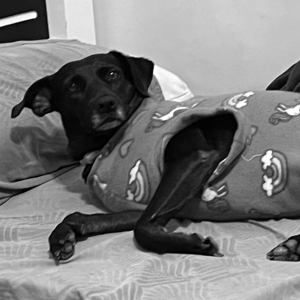

In [17]:
im = Image.open('../data/salem.jpeg')
# redimensiona pra 300x300
im = im.resize((300, 300))
im = im.convert('L')
imarr = np.array(im)
im

### Fourier

A **transformada de Fourier** é uma transformada integral que "decompõe" uma função em várias outras.
Essas saídas são funções de frequência $\in \mathbb{C}$.

$$F(\omega) = \int_{-\infty}^\infty f(t)e^{-j \omega t} dt $$

Essa transformação é frequentemente usada em tratamento do sinais.
Por exemplo, digamos que queremos remover ruído de um sinal de rádio.
Ao decompor a onda recebida em diversas sub-frequências, podemos identificar
qual delas está provocando o ruído, e removê-la.

Depois, basta usar a transformada inversa para reconstruir o sinal original, agora sem o ruído.

$$F^{-1}(\omega) = \frac{1}{2 \pi} \int_{-\infty}^\infty F(\omega) e^{j \omega t} d \omega $$

Faremos um processo similar aqui, só que com imagens.

Para tanto, usaremos a versão 2D e discreta da transformada (DFT). Dada uma imagem de resolução $M \times N$,

$$F(x, y) = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} f(m, n) e^{-j 2 \pi (x \frac{m}{M} + y\frac{n}{N})}$$

$$F^{-1}(x, y) = \frac{1}{MN} \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} F(x, y) e^{j 2 \pi (x \frac{m}{M} + y \frac{n}{N})},$$

onde $f(m, n)$ é um pixel.

Mais precisamente, usaremos a FFT (_Fast Fourier Transform_), algoritmos que implementam a DFT e a iDFT com eficiência computacional.

#### FFT e inversa

Testemos o funcionamento da FFT e da iFFT.

In [18]:
fhat = np.fft.fft2(imarr)
fhat

array([[11194736.         +0.j    ,   432963.6537+813525.029j ,
          158646.5369+320987.3185j, ...,  -284323.6298  +8202.8972j,
          158646.5369-320987.3185j,   432963.6537-813525.029j ],
       [ 2511657.7484-501259.7545j,   263993.1613+310562.622j ,
         -738102.2131 -86100.6352j, ...,  -270506.3915-132238.4545j,
         -293288.4447-214028.3768j, -1291070.4856+328762.9696j],
       [  465472.2381-164871.7122j,  -677036.1326-222278.477j ,
          207308.3119+861003.352j , ...,  -238323.2203-127168.5413j,
           31331.8379-244435.58j  ,  -160043.986 +412825.3553j],
       ...,
       [  -91584.2318-311143.5052j,    50235.2475+191922.2277j,
         -309885.0457-163541.5876j, ...,   156115.3194-176568.0463j,
           -7437.9554+339558.1939j,  -356670.9087 -50888.9322j],
       [  465472.2381+164871.7122j,  -160043.986 -412825.3553j,
           31331.8379+244435.58j  , ...,   -31969.0899-259619.4078j,
          207308.3119-861003.352j ,  -677036.1326+222278.477j ]

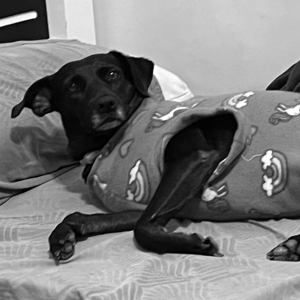

In [22]:
f = np.fft.ifft2(fhat)
imf = np.abs(f)
imf = Image.fromarray(imf)
imf = imf.convert('L')
imf

#### Compressão

Aqui fazemos um teste de compressão.

A transformada de Fourier em imagens tem o comportamento de concentrar as baixas frequências
(que contém os elementos mais importantes, formas básicas, sem detalhes) no centro, enquanto
as altas frequências carregam os detalhes da imagem (texturas, etc.).

Uma forma de comprimir uma imagem é, portanto, manter apenas uma parcela de sua FT, concentrando-se,
claro, nas baixas frequências (ou seja, partimos do centro até atinir uma parcela desejada).

Abaixo temos alguns testes de compressão utilizando 0.2%, 1.0%, 6.0% e 10% da FT.

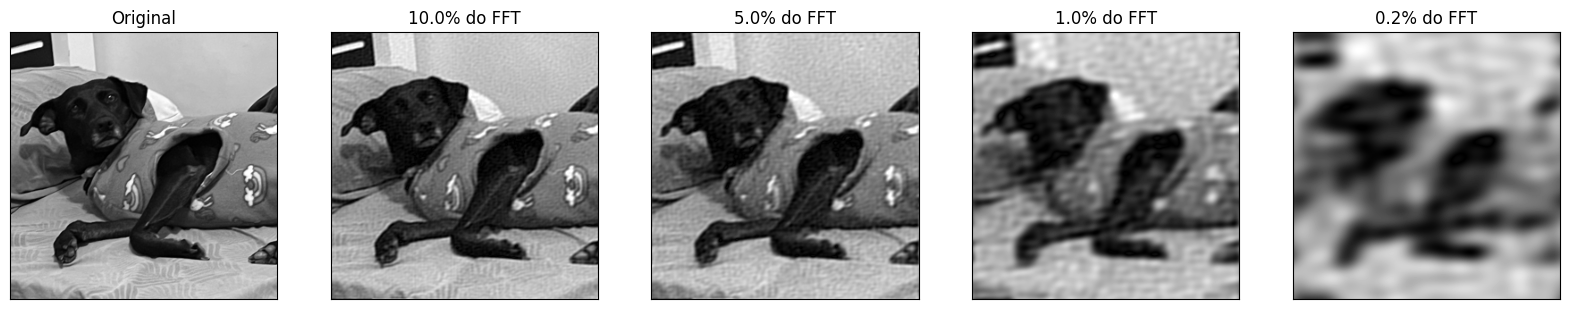

In [36]:
fhat_sort = np.sort(np.abs(fhat).flatten())

# plot 1x5
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(imarr, cmap='gray')
axs[0].set_title('Original')

# zera todos os pequenos coeficientes
i = 1
for keep in [.1, .05, .01, .002]:
    thresh = fhat_sort[int(np.floor((1-keep)*len(fhat_sort)))]
    ind = np.abs(fhat) > thresh
    Atlow = fhat * ind
    Alow = np.abs(np.fft.ifft2(Atlow).real)
    imlow = Image.fromarray(Alow)
    imlow = imlow.convert('L')
    axs[i].imshow(imlow, cmap='gray')
    axs[i].set_title(f'{keep*100}% do FFT')
    i += 1
# remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Uma abordagem menos "crua" (algo mais elaborado do que só "círculo de raio qualquer") de seleção de frequências traria resultados melhores,
como no exemplo em (Brunton, pág. 125).
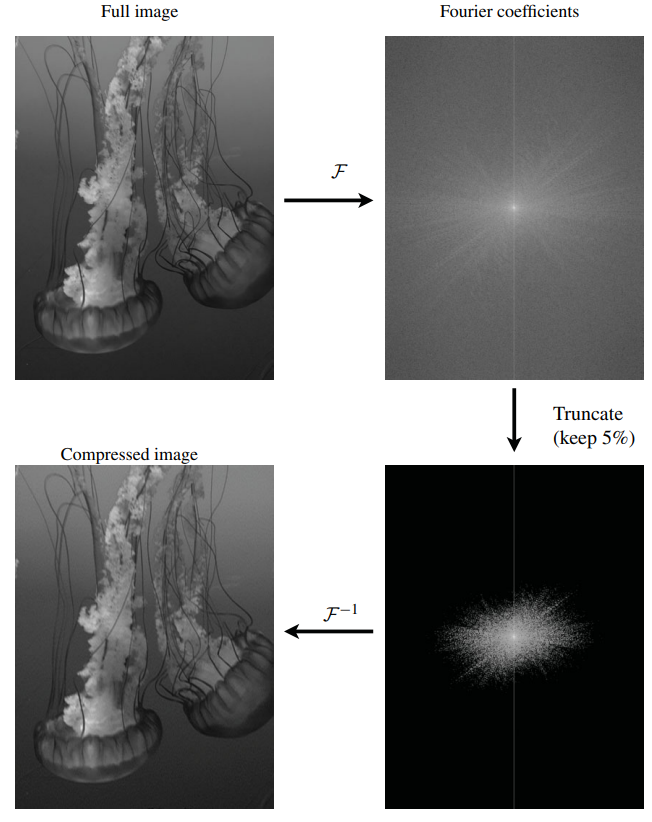

#### Tratamento de ruído

Outra aplicação da FT é no tratamento de ruído.

O princípio é o mesmo da compressão: boa parte dos perfis de ruído concentram-se nas altas frequência.
Podemos então aplicar um filtro passa-baixa no domínio da frequência, a fim de eliminá-los.
Ou seja, eliminamos as altas frequências, mantendo apenas um raio de baixas frequências.
Claro que devemos selecionar o tamanho do raio de forma que não percamos muitos detalhes da imagem.

In [83]:
imnoise = imarr + 20 * np.random.randn(*imarr.shape)
imnoise_t = np.fft.fft2(imnoise)
imnoise_tshift = np.fft.fftshift(imnoise_t)
F = np.log(np.abs(imnoise_tshift) + 1)

In [84]:
nx, ny = imnoise.shape
X, Y = np.meshgrid(np.arange(-ny / 2 + 1, ny / 2 + 1),np.arange(-nx / 2 + 1, nx / 2 + 1))
R2 = np.pow(X, 2) + np.pow(Y, 2)
T = 100
ind = R2 < T**2
imnoise_tshift_filt = imnoise_tshift * ind
Ffilt = np.log(np.abs(imnoise_tshift_filt) + 1)

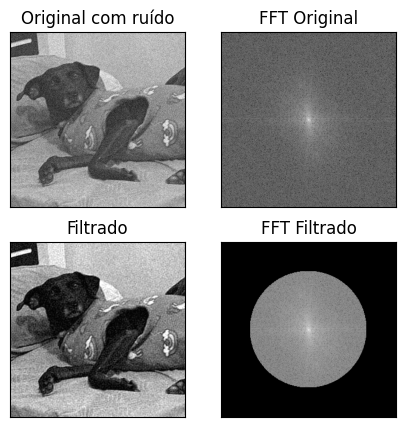

In [85]:
imnoise_filt = np.abs(np.fft.ifft2(np.fft.ifftshift(imnoise_tshift_filt)))
imnoise_filt = Image.fromarray(imnoise_filt)
imnoise_filt = imnoise_filt.convert('L')

# 2x2 plot
# [imnoise, F]
# [imnoise_filt, Ffilt]
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0, 0].imshow(imnoise, cmap='gray')
axs[0, 0].set_title('Original com ruído')
axs[0, 1].imshow(F, cmap='gray')
axs[0, 1].set_title('FFT Original')
axs[1, 0].imshow(imnoise_filt, cmap='gray')
axs[1, 0].set_title('Filtrado')
axs[1, 1].imshow(Ffilt, cmap='gray')
axs[1, 1].set_title('FFT Filtrado')
# remove ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Wavelets

A ideia da transformada Wavelet é decompor uma função
em funções de resolução diferentes.
A partir de uma função inicial $\psi(t)$, 
$$\psi_{a, b}(t) = \frac{1}{\sqrt{a}} \psi \left( \frac{t - b}{a} \right)$$
gera-se versões em diferentes escalas e translações a partir dos parâmetros $a$ e $b$.

O livro traz o exemplo da wavelet de Haar, contudo utiliza em seus códigos (aqui reproduzidos)
a wavelet de Daubechies.

In [87]:
#%pip install PyWavelets

In [88]:
import pywt

#### Decomposição

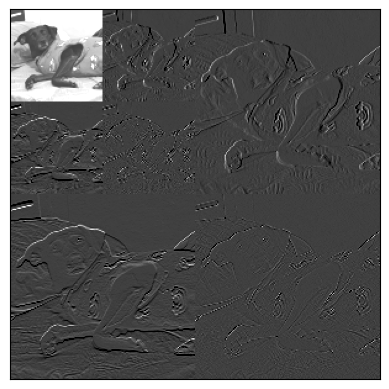

In [92]:
## Wavelet decomposition (2 level)
n = 2
w = 'db1'
coeffs = pywt.wavedec2(imarr,wavelet=w,level=n)

# normalize each coefficient array
coeffs[0] /= np.abs(coeffs[0]).max()
for detail_level in range(n):
    coeffs[detail_level + 1] = [d/np.abs(d).max() for d in coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(coeffs)
plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)
plt.xticks([])
plt.yticks([])
plt.show()

#### Compressão

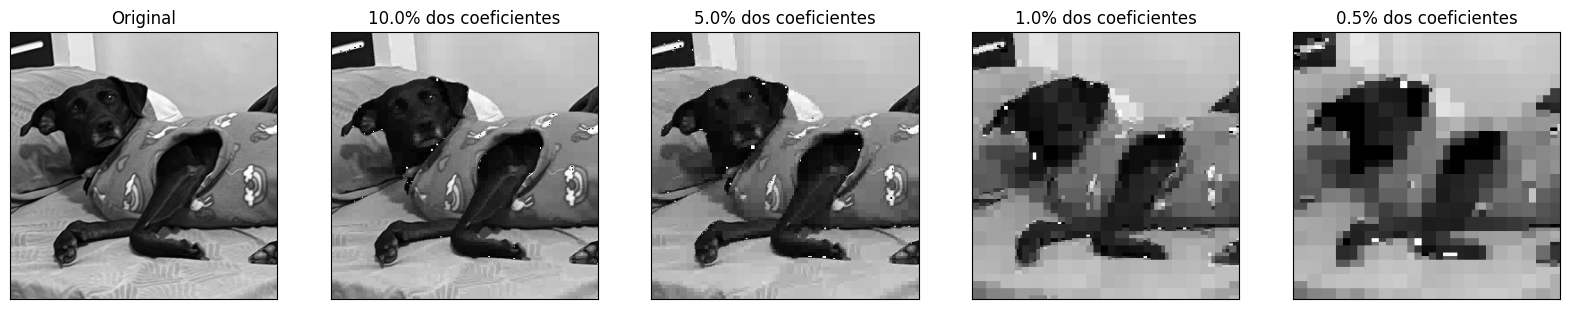

In [95]:
n = 4
w = 'db1'
coeffs = pywt.wavedec2(imarr,wavelet=w,level=n)

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

# plot 1x5
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(imarr, cmap='gray')
axs[0].set_title('Original')

i = 1
for keep in [0.1, 0.05, 0.01, 0.005]:
    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices
    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,
    output_format='wavedec2')
    # Plot reconstruction
    Arecon = pywt.waverec2(coeffs_filt,wavelet=w)
    Arecon_show = Arecon.astype(np.uint8)
    axs[i].imshow(Arecon_show, cmap='gray')
    axs[i].set_title(f'{keep*100}% dos coeficientes')
    i += 1
# remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()